## Import Nessesary Libraries

In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from io import StringIO
from scipy.stats import shapiro
import warnings

## Import OHLC Data from Yahoo Finance

In [3]:
ticker = "USDKES=X"
start_date = "2024-01-01"
end_date = "2024-12-31"

try:
    df1 = yf.download(ticker, start=start_date, end=end_date, progress=False)

    if not df1.empty:
        if isinstance(df1.columns, pd.MultiIndex):
            df1.columns = [col[0] for col in df1.columns]
        df1.reset_index(inplace=True)
        df1.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
        df1['Date'] = pd.to_datetime(df1['Date'], errors='coerce')
        df1['Year'] = df1['Date'].dt.year
        df1['Month'] = df1['Date'].dt.month

    else:
        print("No data found for the specified ticker and time period.")
except Exception as e:
    print(f"An error occurred: {e}")


YF.download() has changed argument auto_adjust default to True


In [4]:
df1.head()

,Date,Close,High,Low,Open,Volume,Year,Month
0,2024-01-01,155.940475,156.529999,156.166489,156.300003,0,2024,1
1,2024-01-02,156.440002,156.500000,155.699997,156.440002,0,2024,1
2,2024-01-03,156.350006,156.600006,155.600006,156.350006,0,2024,1
3,2024-01-04,156.350006,156.940002,156.000000,156.350006,0,2024,1
4,2024-01-05,156.649994,157.199997,156.199997,156.649994,0,2024,1


## EDA on Price Data

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    261 non-null    datetime64[ns]
 1   Close   261 non-null    float64       
 2   High    261 non-null    float64       
 3   Low     261 non-null    float64       
 4   Open    261 non-null    float64       
 5   Volume  261 non-null    int64         
 6   Year    261 non-null    int32         
 7   Month   261 non-null    int32         
dtypes: datetime64[ns](1), float64(4), int32(2), int64(1)
memory usage: 14.4 KB


In [6]:
df1.describe()

,Date,Close,High,Low,Open,Volume,Year,Month
count,261,261.000000,261.000000,261.000000,261.000000,261.0,261.0,261.000000
mean,2024-06-30 04:52:24.827586304,133.945910,134.535457,133.316327,133.932030,0.0,2024.0,6.475096
min,2024-01-01 00:00:00,126.129997,127.500000,126.101440,126.129997,0.0,2024.0,1.000000
25%,2024-04-01 00:00:00,128.000000,128.380005,127.750000,128.000000,0.0,2024.0,4.000000
50%,2024-07-01 00:00:00,128.699997,129.089996,128.229996,128.500000,0.0,2024.0,7.000000
75%,2024-09-30 00:00:00,133.000000,133.500000,131.500000,133.000000,0.0,2024.0,9.000000
max,2024-12-30 00:00:00,163.000000,163.210007,161.570007,162.990005,0.0,2024.0,12.000000
std,NaN,10.562897,10.651078,10.195395,10.539170,0.0,0.0,3.453587


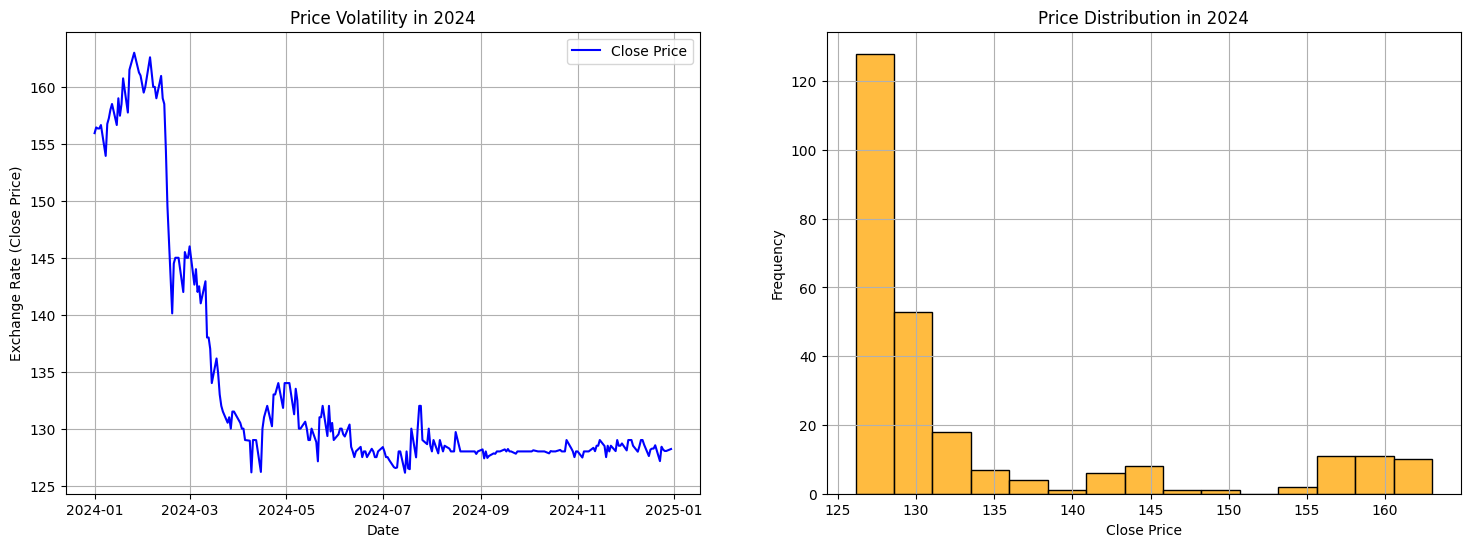

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(df1['Date'], df1['Close'], label='Close Price', color='blue')
axes[0].set_title('Price Volatility in 2024')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Exchange Rate (Close Price)')
axes[0].legend()
axes[0].grid(True)

sns.histplot(df1['Close'], kde=False, bins=15, ax=axes[1], color='orange')
axes[1].set_title('Price Distribution in 2024')
axes[1].set_xlabel('Close Price')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plot1_path = 'Price_Volatility_lineplot.png'
plot2_path = 'Price_Distribution_histogram.png'

In [8]:
df_rates = df1[['Year','Month','Close']].groupby(['Year','Month']).mean().reset_index()
df_rates

,Year,Month,Close
0,2024,1,158.600657
1,2024,2,152.474184
2,2024,3,136.672081
3,2024,4,130.571365
4,2024,5,130.800870
5,2024,6,128.459999
6,2024,7,128.220676
7,2024,8,128.207273
8,2024,9,127.924315
9,2024,10,128.037392


In [9]:
df_rates.to_csv('df_rates.csv')

## Get Import Data

In [11]:
df2 = pd.read_excel('Import data.xlsx')
df2.head()

,Year,Month,STATION,PLACEOFDISCHARGE,Station Name,CONSIGNEENAME,NumberOfContainers,ContainerAgeInDays
0,2024,1,ATN,AT2,AUTOPORT FREIGHT TERMINAL NAIROBI,A&amp;n Industries Limited,2,302
1,2024,1,ATN,AT2,AUTOPORT FREIGHT TERMINAL NAIROBI,A&amp;n Industries Limited,4,307
2,2024,1,ATN,AT2,AUTOPORT FREIGHT TERMINAL NAIROBI,African Retail Traders (2005) Limited,11,296
3,2024,1,ATN,AT2,AUTOPORT FREIGHT TERMINAL NAIROBI,Akiyda Two Thousand Limited,4,299
4,2024,1,ATN,AT2,AUTOPORT FREIGHT TERMINAL NAIROBI,ALAN DICK COMPANY (EAST AFRICA) LIMITED,2,315


## EDA on Import Data

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83395 entries, 0 to 83394
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Year                83395 non-null  int64 
 1   Month               83395 non-null  int64 
 2   STATION             83395 non-null  object
 3   PLACEOFDISCHARGE    83395 non-null  object
 4   Station Name        83395 non-null  object
 5   CONSIGNEENAME       83395 non-null  object
 6   NumberOfContainers  83395 non-null  int64 
 7   ContainerAgeInDays  83395 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 5.1+ MB


In [13]:
df2_volumes = df2[['Year','Month','NumberOfContainers']].groupby(['Year','Month']).sum().reset_index()
df2_volumes

,Year,Month,NumberOfContainers
0,2024,1,22374
1,2024,2,19569
2,2024,3,22591
3,2024,4,24338
4,2024,5,21461
5,2024,6,18241
6,2024,7,22587
7,2024,8,20435
8,2024,9,20635
9,2024,10,22685


In [14]:
df2_volumes.describe()

,Year,Month,NumberOfContainers
count,11.0,11.000000,11.000000
mean,2024.0,6.000000,20795.636364
std,0.0,3.316625,2865.440534
min,2024.0,1.000000,13836.000000
25%,2024.0,3.500000,20002.000000
50%,2024.0,6.000000,21461.000000
75%,2024.0,8.500000,22589.000000
max,2024.0,11.000000,24338.000000


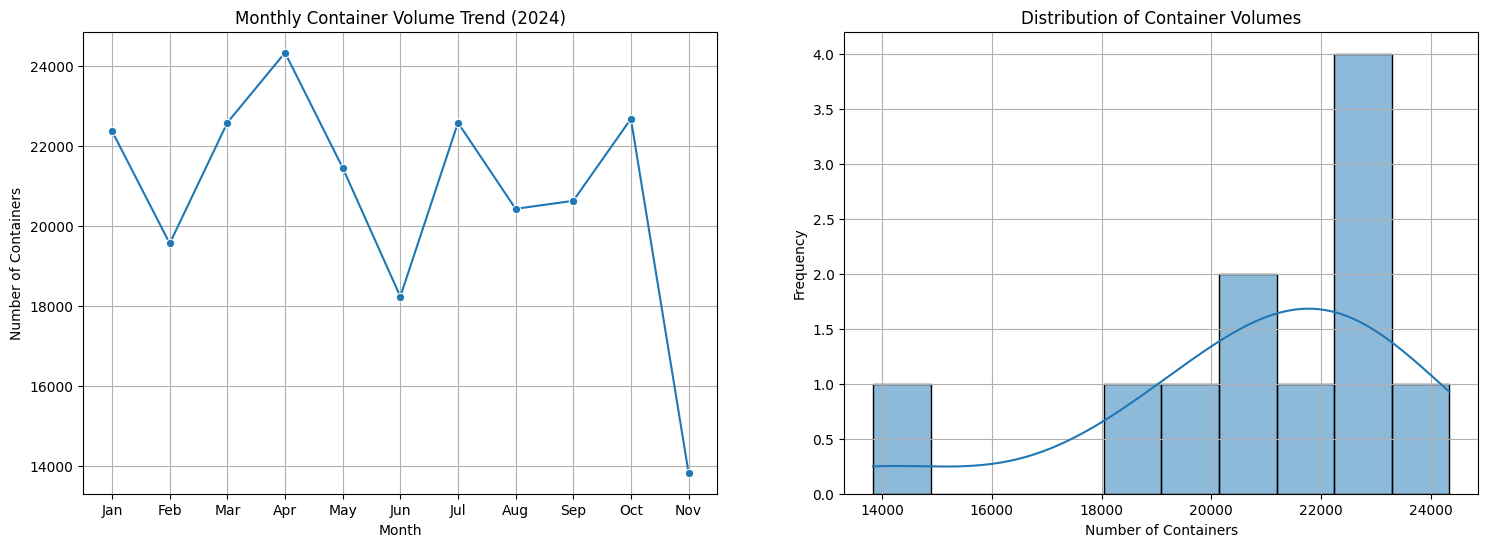

In [15]:
df2_volumes['Month_Name'] = df2_volumes['Month'].apply(lambda x: calendar.month_abbr[x])

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.lineplot(data=df2_volumes, x='Month_Name', y='NumberOfContainers', marker='o', ax=axes[0])
axes[0].set_title('Monthly Container Volume Trend (2024)')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Containers')
axes[0].grid(True)

sns.histplot(df2_volumes['NumberOfContainers'], kde=True, bins=10, ax=axes[1])
axes[1].set_title('Distribution of Container Volumes')
axes[1].set_xlabel('Number of Containers')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plot1_path = 'Monthly_Container_Volume_Trend.png'
plot2_path = 'Distribution_of_Container_Volumes.png'

## Merge the Price & Import Data

In [16]:
df3 = pd.merge(df2_volumes, df_rates, on=['Year', 'Month'], how='left')
df3.head(12)

,Year,Month,NumberOfContainers,Month_Name,Close
0,2024,1,22374,Jan,158.600657
1,2024,2,19569,Feb,152.474184
2,2024,3,22591,Mar,136.672081
3,2024,4,24338,Apr,130.571365
4,2024,5,21461,May,130.800870
5,2024,6,18241,Jun,128.459999
6,2024,7,22587,Jul,128.220676
7,2024,8,20435,Aug,128.207273
8,2024,9,20635,Sep,127.924315
9,2024,10,22685,Oct,128.037392


In [17]:
df3.to_csv('df3.csv')

## Visualizing the Relationship (Hypothesis Testing)

In [27]:
# Step 1: Scale the data
scaler = MinMaxScaler()
df3[['Scaled_Containers', 'Scaled_Close']] = scaler.fit_transform(df3[['NumberOfContainers', 'Close']])

# Step 2: Create lagged containers column
df3['Scaled_Lagged_Containers'] = df3['Scaled_Containers'].shift(1)

# Step 3: Add month names for better visualization
df3['Month_Name'] = df3['Month'].apply(lambda x: calendar.month_abbr[x])

# Step 4: Plot the first graph (Lagged Import Volumes vs Exchange Rates)
plt.figure(figsize=(10, 6))
ax1 = plt.gca()  # Get current axis
ax1.plot(df3['Month_Name'], df3['Scaled_Lagged_Containers'], label='Number of Containers', color='tab:blue', marker='o')
ax1.plot(df3['Month_Name'], df3['Scaled_Close'], label='Lagged Exchange Rate', color='tab:red', marker='o')
ax1.set_title('Lagged Import Volumes vs Exchange Rates')
ax1.set_xlabel('Month')
ax1.set_ylabel('Scaled Values')
ax1.legend()
ax1.grid(True)

# Save the first plot as a separate image
plot1_path = 'Lagged_Import_Volumes_vs_Monthly_Exchange_Rates.png'
plt.savefig(plot1_path)
plt.close()  # Close the current figure to free memory

# Step 5: Compute correlation matrix and plot the heatmap
correlation_matrix = df3[['Scaled_Lagged_Containers', 'Scaled_Close']].corr()

plt.figure(figsize=(6, 6))
ax2 = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
ax2.set_title('Correlation between Import Volumes & Exchange Rates')
ax2.set_xticklabels(['Containers', 'Exchange Rate'], rotation=360)
ax2.set_yticklabels(['Containers', 'Exchange Rate'], rotation=0)

# Save the second plot as a separate image
plot2_path = 'Correlation_Heatmap.png'
plt.savefig(plot2_path)
plt.close()  # Close the current figure to free memory

# Show the plots (optional, if you want to visualize them in the notebook)
plt.show()

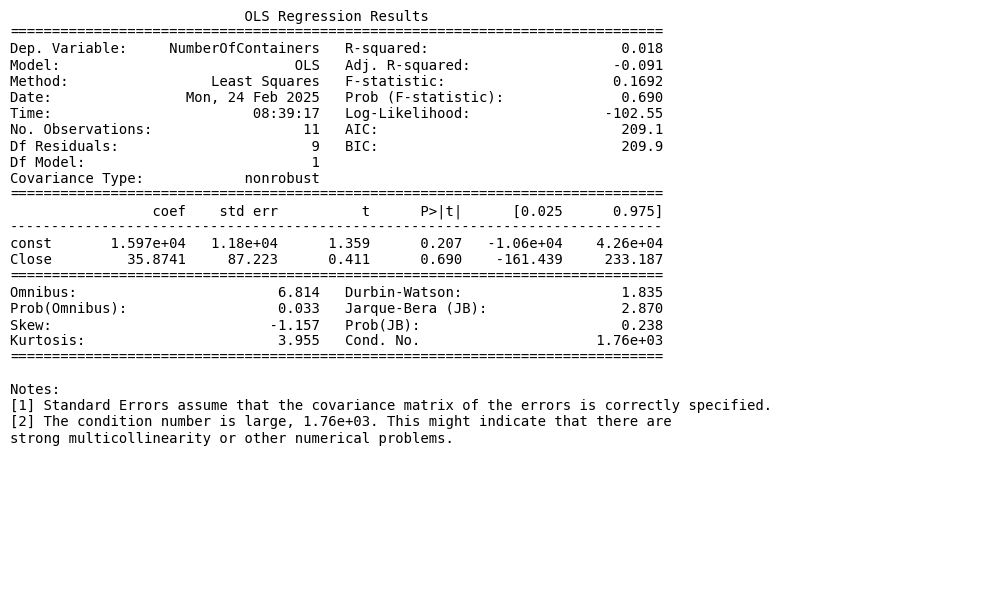

In [20]:
warnings.filterwarnings("ignore", message="kurtosistest only valid for n>=20")

X = sm.add_constant(df3['Close'])
y = df3['NumberOfContainers']
model = sm.OLS(y, X).fit()
regression_summary = model.summary()

adf_close = adfuller(df3['Close'])
adf_containers = adfuller(df3['NumberOfContainers'])

adf_results = {
    'Close': {'ADF Statistic': adf_close[0], 'p-value': adf_close[1]},
    'NumberOfContainers': {'ADF Statistic': adf_containers[0], 'p-value': adf_containers[1]}
}

residuals = model.resid
shapiro_stat, shapiro_p_value = shapiro(residuals)

shapiro_results = {
    "Shapiro-Wilk Test Statistic": shapiro_stat,
    "p-value": shapiro_p_value,
    "Conclusion": "Residuals are normally distributed"
    if shapiro_p_value > 0.05
    else "Residuals are not normally distributed",
}

regression_summary_text = regression_summary.as_text()

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')
ax.text(0, 1, regression_summary_text, fontsize=10, family='monospace', va='top')

plt.tight_layout()
plt.savefig("regression_summary.png", dpi=300, bbox_inches='tight')
plt.show()
